# [5-3] JETANK_2_ctrl

이 문서는 JETANK 제어 기능을 구축하는 데 사용되며, 페이지의 버튼을 사용하여 JETANK를 제어합니다. 또한 버튼에 대한 기능을 사용자 정의할 수 있습니다.

## 카메라 클래스를 가져오기
다음 코드를 실행하여 카메라 위젯을 엽니다. 화면이 열리면 화면을 마우스 오른쪽 버튼으로 클릭하여 "출력용 새 보기 만들기"를 선택한 다음, 화면을 적절한 위치로 끌어다 놓을 수 있습니다.

In [ ]:
import traitlets
import ipywidgets.widgets as widgets
from IPython.display import display
# from jetbot import Camera, bgr8_to_jpeg
from robotpal import Camera, bgr8_to_jpeg
camera = Camera.instance(width=300, height=300)
#카메라로 찍은 frame 을 띄워줄 image 객체 생성, 크기를 맞출 필요는 없다.
image = widgets.Image(format='jpeg', width=300, height=300) 

camera_link = traitlets.dlink((camera, 'value'), (image, 'value'), transform=bgr8_to_jpeg)

display(image)

[RobotPal] 서버 시작됨 | WebSocket: 9999, TCP: 9998
[RobotPal] 통신 대기 중... (WS: 9999, TCP: 9998)


Image(value=b'', format='jpeg', height='300', width='300')

[System] WebSocket 프로세서 시작
[TCP] 클라이언트 연결됨 (('127.0.0.1', 61854))


실행 결과  
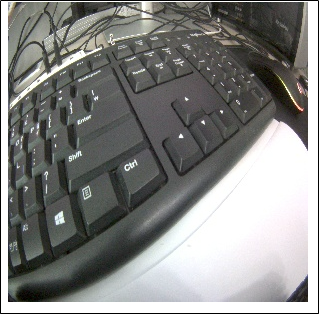

다음으로, 카메라의 팬 및 틸트 움직임을 제어하기 위한 몇 개의 버튼을 생성하고 관련 제어 기능을 설정합니다. 먼저 서보를 제어하는 데 사용되는 라이브러리를 가져와서, 카메라의 수평 (팬) 및 수직 (틸트) 위치를 저장할 전역 변수 2개를 사용하세요.

In [2]:
from robotpal.SCSCtrl import TTLServo

servoPos_1 = 0  # 카메라 Pan 위치 변수
servoPos_5 = 0  # 카메라 수직 위치 변수

#범위 제한 함수
def limitCtl(maxInput, minInput, rawInput):
    if rawInput > maxInput:
        limitBuffer = maxInput
    elif rawInput < minInput:
        limitBuffer = minInput
    else:
        limitBuffer = rawInput
    return limitBuffer

#카메라 방향 제어 함수들
def cameraUp():
    global servoPos_5
    servoPos_5 = limitCtl(25, -40, servoPos_5-15)
    TTLServo.servoAngleCtrl(5, servoPos_5, 1, 150)

def cameraDown():
    global servoPos_5
    servoPos_5 = limitCtl(25, -40, servoPos_5+15)
    TTLServo.servoAngleCtrl(5, servoPos_5, 1, 150)

def ptRight():
    global servoPos_1
    servoPos_1 = limitCtl(80, -80, servoPos_1+15)
    TTLServo.servoAngleCtrl(1, servoPos_1, 1, 150)

def ptLeft():
    global servoPos_1
    servoPos_1 = limitCtl(80, -80, servoPos_1-15)
    TTLServo.servoAngleCtrl(1, servoPos_1, 1, 150)


실행 결과  
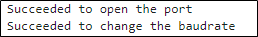  
버튼을 배치하기 위한 레이아웃을 추가하십시오.

In [3]:
PT_layout = widgets.Layout(width='100px', height='80px', align_self='center')
cameraUp_button = widgets.Button(description='LookUp', button_style='success', layout=PT_layout)
cameraDown_button = widgets.Button(description='LookDown', button_style='success', layout=PT_layout)
ptRight_button = widgets.Button(description='LookRight', button_style='success', layout=PT_layout)
ptLeft_button = widgets.Button(description='LookLeft', button_style='success', layout=PT_layout)

subPT_box = widgets.HBox([ptLeft_button, cameraDown_button, ptRight_button], layout=widgets.Layout(align_self='center'))
surPT_box = widgets.VBox([cameraUp_button, subPT_box])
display(surPT_box)

#버튼과 함수를 연결합니다.
cameraUp_button.on_click(lambda x: cameraUp())
cameraDown_button.on_click(lambda x: cameraDown())
ptRight_button.on_click(lambda x: ptRight())
ptLeft_button.on_click(lambda x: ptLeft())


실행 결과  
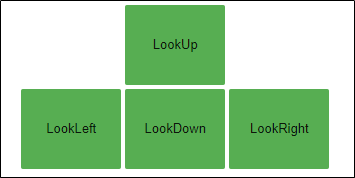  

## 차량 제어 
차량을 제어하기 위해 몇 개의 버튼을 만드십시오. 다음 코드는 basic_motion에서 가져온 것입니다.


In [4]:
from robotpal import Robot
import time

robot = Robot()

# 버튼 생성
button_layout = widgets.Layout(width='100px', height='80px', align_self='center')
stop_button = widgets.Button(description='stop', button_style='danger', layout=button_layout)
forward_button = widgets.Button(description='forward', layout=button_layout)
backward_button = widgets.Button(description='backward', layout=button_layout)
left_button = widgets.Button(description='left', layout=button_layout)
right_button = widgets.Button(description='right', layout=button_layout)

# 버튼 배치 코드
middle_box = widgets.HBox([left_button, stop_button, right_button], layout=widgets.Layout(align_self='center'))
controls_box = widgets.VBox([forward_button, middle_box, backward_button])
display(controls_box)

#모터 제어 함수
def stop(change):
    robot.stop()
    
def step_forward(change):
    robot.forward(0.4)

def step_backward(change):
    robot.backward(0.4)

def step_left(change):
    robot.left(0.3)
    time.sleep(0.5)
    robot.stop()

def step_right(change):
    robot.right(0.3)
    time.sleep(0.5)
    robot.stop()
    
# 버튼과 함수를 연결합니다.
stop_button.on_click(stop)
forward_button.on_click(step_forward)
backward_button.on_click(step_backward)
left_button.on_click(step_left)
right_button.on_click(step_right)


실행 결과  
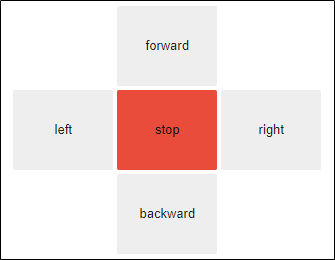  

다음 코드는 서보를 제어하는 데 사용되는 버튼을 만듭니다. 로봇 팔의 끝과 그리퍼의 위치를 저장하기 위해 xPos, yPos 및 servoPos_4와 같은 세 개의 전역 변수가 필요합니다.

In [5]:
import ipywidgets as widgets
from IPython.display import display
from robotpal.SCSCtrl import TTLServo 

# --- 1. 변수 초기화 ---
xPos = 150      # 초기 X 좌표 (안전 범위 내)
yPos = 0        # 초기 Y 좌표
servoPos_1 = 0  # Camera Pan (좌우)
servoPos_4 = 0  # Gripper (집게)
servoPos_5 = 0  # Camera Tilt (상하)

out = widgets.Output()

# --- 2. 헬퍼 함수 ---
def limitCtl(maxInput, minInput, rawInput):
    if rawInput > maxInput: return maxInput
    elif rawInput < minInput: return minInput
    else: return rawInput

# --- 3. 로봇 팔 제어 함수 (로직 수정됨) ---
def xIn(): # X+ (Forward)
    with out: 
        global xPos
        # 최대 거리 제한 (220)
        if xPos < 220:
            xPos += 10
            TTLServo.xyInput(xPos, yPos)
            print(f"X+ | xPos: {xPos}, yPos: {yPos}")
        else:
            print("Max Distance Reached")

def xDe(): # X- (Backward)
    with out:
        global xPos
        # 최소 거리 제한 (80)
        if xPos > 80:
            xPos -= 10
            TTLServo.xyInput(xPos, yPos)
            print(f"X- | xPos: {xPos}, yPos: {yPos}")
        else:
            print("Min Distance Reached")

def yIn(): # Y+ (Up)
    with out:
        global yPos
        # 높이 제한 (150)
        if yPos < 150:
            yPos += 10
            TTLServo.xyInput(xPos, yPos)
            print(f"Y+ | xPos: {xPos}, yPos: {yPos}")
        else:
            print("Max Height Reached")

def yDe(): # Y- (Down)
    with out:
        global yPos
        # 바닥 제한 (-100)
        if yPos > -100:
            yPos -= 10
            TTLServo.xyInput(xPos, yPos)
            print(f"Y- | xPos: {xPos}, yPos: {yPos}")
        else:
            print("Min Height Reached")

def grab(): # Grab
    with out:
        global servoPos_4
        # 닫기 (값 감소)
        servoPos_4 -= 15
        if servoPos_4 < -90: servoPos_4 = -90
        TTLServo.servoAngleCtrl(4, servoPos_4, 1, 150)
        print(f"Grab | Val: {servoPos_4}")

def loose(): # Loose
    with out:
        global servoPos_4
        # 열기 (값 증가)
        servoPos_4 += 15
        if servoPos_4 > 0: servoPos_4 = 0
        TTLServo.servoAngleCtrl(4, servoPos_4, 1, 150)
        print(f"Loose | Val: {servoPos_4}")

# --- 5. UI 생성 (기존 레이아웃 복원) ---
# 기존 스타일: width=100px, height=80px
full_layout = widgets.Layout(width='100px', height='80px', align_self='center')

# [Arm Buttons]
xIn_button = widgets.Button(description='X+', button_style='success', layout=full_layout)
xDe_button = widgets.Button(description='X-', button_style='success', layout=full_layout)
yIn_button = widgets.Button(description='Y+', button_style='success', layout=full_layout)
yDe_button = widgets.Button(description='Y-', button_style='success', layout=full_layout)
grab_button = widgets.Button(description='Grab', layout=full_layout)   # 스타일 없음
loose_button = widgets.Button(description='Loose', layout=full_layout) # 스타일 없음

# --- 6. 레이아웃 배치 ---
# Arm Box
line1_box = widgets.HBox([xIn_button, yIn_button])
line2_box = widgets.HBox([xDe_button, yDe_button])
line3_box = widgets.HBox([grab_button, loose_button])
arm_box = widgets.VBox([line1_box, line2_box, line3_box])

# 전체 표시
display(arm_box, out)

# --- 7. 이벤트 연결 ---
xIn_button.on_click(lambda x: xIn())
xDe_button.on_click(lambda x: xDe())
yIn_button.on_click(lambda x: yIn())
yDe_button.on_click(lambda x: yDe())
grab_button.on_click(lambda x: grab())
loose_button.on_click(lambda x: loose())


Output()

실행 결과  
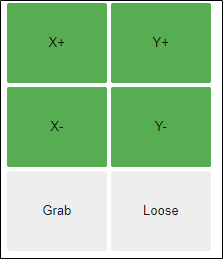  

버튼과 함수를 바인딩합니다.  

In [6]:
xIn_button.on_click(lambda x: xIn())
xDe_button.on_click(lambda x: xDe())

yIn_button.on_click(lambda x: yIn())
yDe_button.on_click(lambda x: yDe())

grab_button.on_click(lambda x: grab())
loose_button.on_click(lambda x: loose())

다시 한 번 카메라 연결을 적절하게 종료하여 나중에 노트북에서 카메라를 사용할 수 있도록 합시다.

In [2]:
camera.stop()